In [ ]:
!pip3 install pymemcache

In [ ]:
import json
import os
import random
import signal
import statistics as stats
import sys
import time
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict

import matplotlib.pyplot as plt

from peercache.parser.manager import NetworkManager
from peercache.parser.network import Network
from peercache.parser.peer import Peer

In [ ]:
NETWORK_NAME   = "extreme_test"
PEERS          = 8         
MEMORY_MB      = 32         
VALUE_SIZE     = 16_384    
GHOST_RATIO    = 0.15      
TTL_RATIO      = 0.25     
LOAD_SCENARIOS = [
    (2,   400),
    (4,   800),
    (8,  200),
    (16, 100),
]

random.seed(42)

In [ ]:

def randval() -> str:
    return os.urandom(VALUE_SIZE).hex()


def pct(a: List[float], q: float) -> float:
    if not a:
        return 0.0
    k = int(round(q / 100 * (len(a) - 1)))
    return sorted(a)[k]


def one_worker(net: Network, wid: int, requests: int) -> Dict[str, List[float]]:
    """
    Mixed workload:
        • warm-up write pass (once per worker)
        • 80 % reads / 20 % writes
        • GHOST_RATIO chance of reading an unknown key
    Returns latency list and key counters.
    """
    lat = []
    hits = misses = evict_writes = 0

    keyspace = [f"{wid}:{i}" for i in range(requests)]

    for k in keyspace:
        t0 = time.perf_counter_ns()
        net.cache_set(k, randval())
        lat.append((time.perf_counter_ns() - t0) / 1_000)

    time.sleep(0.1)

    for _ in range(requests):
        if random.random() < 0.80:    
            ghost = random.random() < GHOST_RATIO
            k = f"ghost:{random.randint(0, 1_000_000)}" if ghost else random.choice(keyspace)
            t0 = time.perf_counter_ns()
            res = net.cache_get(k)
            lat.append((time.perf_counter_ns() - t0) / 1_000)
            if res == "MISS":
                misses += 1
            else:
                hits += 1
        else:                         
            k = random.choice(keyspace)
            ttl = 2 if random.random() < TTL_RATIO else 0
            pids = net.ring.get_n(k, 1)
            for pid in pids:
                peer = Peer(pid)
                peer._client().set(k, randval(), expire=ttl)
            evict_writes += 1

    return {
        "lat": lat,
        "hits": [hits],
        "misses": [misses],
        "writes": [evict_writes],
    }


def run_stage(net: Network, workers: int, reqs: int) -> Dict:
    t0 = time.perf_counter()
    agg = defaultdict(list)

    with ThreadPoolExecutor(max_workers=workers) as pool:
        futs = [pool.submit(one_worker, net, w, reqs) for w in range(workers)]
        for f in as_completed(futs):
            res = f.result()
            for k, v in res.items():
                agg[k].extend(v)

    dur = time.perf_counter() - t0
    total_ops = workers * reqs * 2        
    thr = total_ops / dur

    evictions = bytes_used = 0
    for pid in net.peers:
        s = Peer(pid).stats()
        evictions  += int(s["evictions"])
        bytes_used += int(s["bytes"])

    hits    = sum(agg["hits"])
    misses  = sum(agg["misses"])
    hitrate = hits / (hits + misses) if hits + misses else 0

    return {
        "workers": workers,
        "reqs_per_worker": reqs,
        "ops": total_ops,
        "dur": dur,
        "thr": thr,
        "lat_avg": stats.mean(agg["lat"]),
        "lat_p95": pct(agg["lat"], 95),
        "hits": hits,
        "misses": misses,
        "hit_rate": hitrate,
        "evictions": evictions,
        "bytes": bytes_used,
    }

In [ ]:
def main():
    mgr = NetworkManager()
    print(mgr.create_network(NETWORK_NAME))
    net = Network(NETWORK_NAME)
    peers = []
    for i in range(PEERS):
        p = Peer(f"peer{i}")
        print(p.start(memory_mb=MEMORY_MB))
        peers.append(p)
        print(net.add_peer(p.id))

    res = []
    for w, r in LOAD_SCENARIOS:
        print(f"\n▶ Stage: {w} workers × {r} req")
        stage = run_stage(net, w, r)
        res.append(stage)
        print(json.dumps(stage, indent=2))
        # tiny pause to let TTL items expire & evict next round
        time.sleep(2.5)

    x = [r["workers"] for r in res]

    def save(fig, name):
        fig.tight_layout()
        fig.savefig(name, dpi=120)

    # 1. Throughput
    fig1 = plt.figure()
    plt.plot(x, [r["thr"] for r in res], "o-")
    plt.title("Throughput")
    plt.xlabel("Workers")
    plt.ylabel("Ops/s")
    plt.grid(True)
    save(fig1, "1_throughput.png")

    # 2. Latency: avg & p95
    fig2, ax = plt.subplots()
    ax.plot(x, [r["lat_avg"] for r in res], "o-", label="avg")
    ax.plot(x, [r["lat_p95"] for r in res], "s--", label="p95")
    ax.set_title("Latency")
    ax.set_xlabel("Workers")
    ax.set_ylabel("µs")
    ax.grid(True)
    ax.legend()
    save(fig2, "2_latency.png")

    # 3. Hit vs Miss %
    fig3 = plt.figure()
    plt.bar(x, [r["hit_rate"] * 100 for r in res], label="Hit %")
    plt.bar(x, [100 - r["hit_rate"] * 100 for r in res],
            bottom=[r["hit_rate"] * 100 for r in res],
            label="Miss %", alpha=0.4)
    plt.title("Hit / Miss rate")
    plt.xlabel("Workers")
    plt.ylabel("%")
    plt.ylim(0, 105)
    plt.grid(axis="y")
    plt.legend()
    save(fig3, "3_hit_miss.png")

    # 4. Evictions
    fig4 = plt.figure()
    plt.plot(x, [r["evictions"] for r in res], "d-", color="tab:red")
    plt.title("Evictions")
    plt.xlabel("Workers")
    plt.ylabel("Total evictions")
    plt.grid(True)
    save(fig4, "4_evictions.png")

    # 5. Memory in usea
    fig5 = plt.figure()
    plt.plot(x, [r["bytes"] / 1_048_576 for r in res], "p-")
    plt.title("Bytes in use")
    plt.xlabel("Workers")
    plt.ylabel("MB")
    plt.grid(True)
    save(fig5, "5_memory.png")

    plt.show()

if __name__ == "__main__":
    main()

!pkill -f memcached && rm -rf state/peer/*.json state/network/*.json && echo "Cleaned up all peers and networks."


▶ Stage: 2 workers × 400 req
{
  "workers": 2,
  "reqs": 400,
  "ops": 1600,
  "dur": 2.4488939589937218,
  "thr": 653.3561790717382,
  "lat_avg": 2993.8823249122806,
  "lat_p95": 3867.375,
  "hits": 546,
  "misses": 79,
  "hit_rate": 0.8736,
  "evictions": 0,
  "bytes": 26265380
}

▶ Stage: 4 workers × 800 req
{
  "workers": 4,
  "reqs": 800,
  "ops": 6400,
  "dur": 9.04192183399573,
  "thr": 707.8141259679267,
  "lat_avg": 5578.843160788382,
  "lat_p95": 6983.459,
  "hits": 2167,
  "misses": 417,
  "hit_rate": 0.8386222910216719,
  "evictions": 0,
  "bytes": 104405323
}

▶ Stage: 8 workers × 200 req
{
  "workers": 8,
  "reqs": 200,
  "ops": 3200,
  "dur": 4.754178875009529,
  "thr": 673.0920489384375,
  "lat_avg": 11651.234804272915,
  "lat_p95": 16465.875,
  "hits": 1122,
  "misses": 180,
  "hit_rate": 0.8617511520737328,
  "evictions": 0,
  "bytes": 129488530
}

▶ Stage: 16 workers × 100 req
{
  "workers": 16,
  "reqs": 100,
  "ops": 3200,
  "dur": 4.52619337500073,
  "thr": 706.9

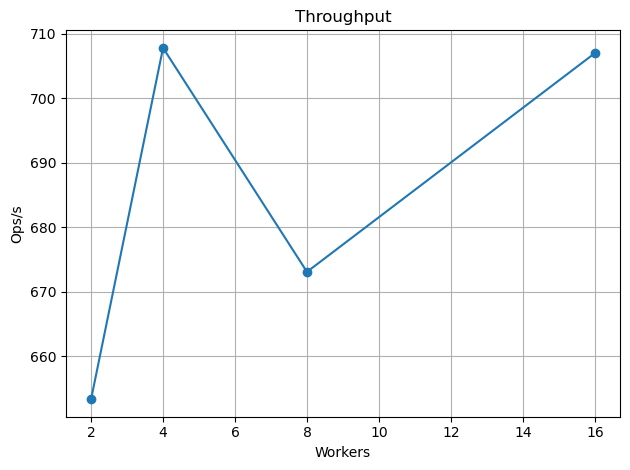

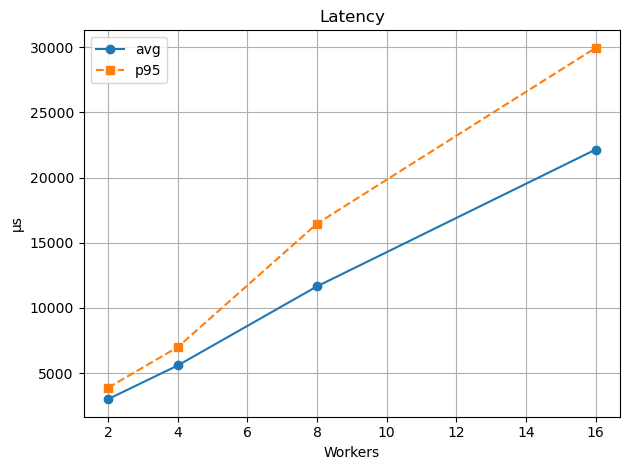

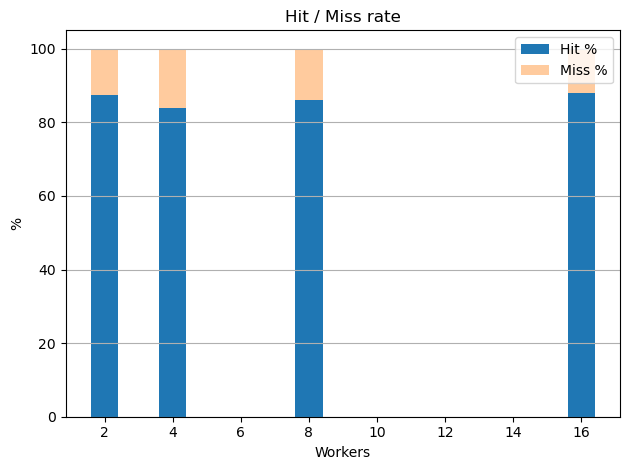

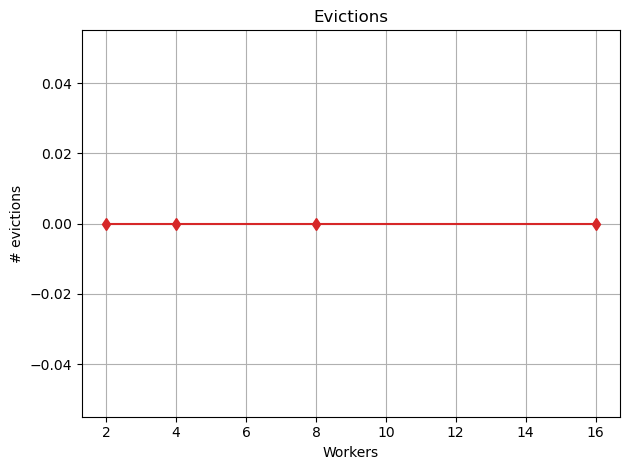

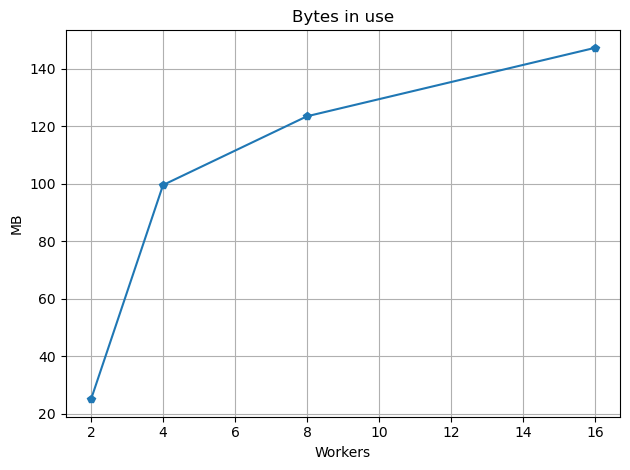

🔖 Results saved → state/stats/baseline_20250607_033946.json
Cleaned up all peers and networks.


In [1]:
from testing.benchmark import run_benchmark

run_benchmark(
    name="baseline",
    peers=8,
    memory_mb=32,
    scenarios=[(2, 400), (4, 800), (8, 200), (16, 100)],
)
!pkill -f memcached && rm -rf state/peer/*.json state/network/*.json && echo "Cleaned up all peers and networks."


▶ Stage: 1 workers × 200 req
{
  "workers": 1,
  "reqs": 200,
  "ops": 400,
  "dur": 0.477402999997139,
  "thr": 837.8665404331291,
  "lat_avg": 1069.2180309859154,
  "lat_p95": 1469.792,
  "hits": 91,
  "misses": 64,
  "hit_rate": 0.5870967741935483,
  "evictions": 89,
  "bytes": 16007975
}

▶ Stage: 2 workers × 400 req
{
  "workers": 2,
  "reqs": 400,
  "ops": 1600,
  "dur": 0.9776665829995181,
  "thr": 1636.5497479632977,
  "lat_avg": 1139.5321485355648,
  "lat_p95": 1635.959,
  "hits": 95,
  "misses": 539,
  "hit_rate": 0.1498422712933754,
  "evictions": 994,
  "bytes": 16264096
}

🔧 Configuration:
{
  "name": "low_mem_big_obj",
  "peers": 4,
  "memory_mb": 4,
  "value_size": 64000,
  "ghost_ratio": 0.15,
  "ttl_ratio": 0.25,
  "scenarios": [
    [
      1,
      200
    ],
    [
      2,
      400
    ]
  ],
  "seed": 42
}
🖼️ Saved plot → state/stats/low_mem_big_obj_throughput.png
🖼️ Saved plot → state/stats/low_mem_big_obj_latency.png
🖼️ Saved plot → state/stats/low_mem_big_obj_

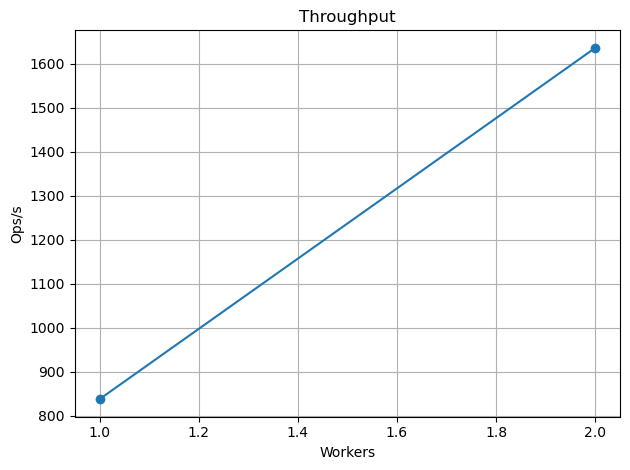

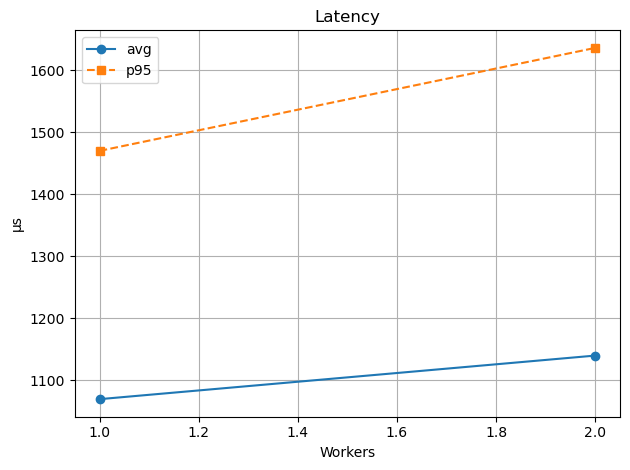

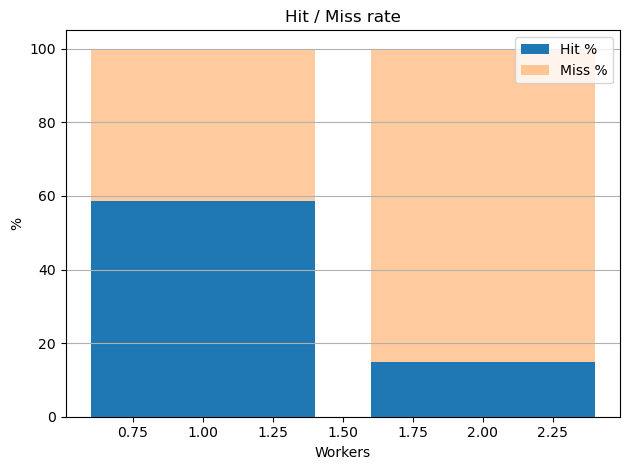

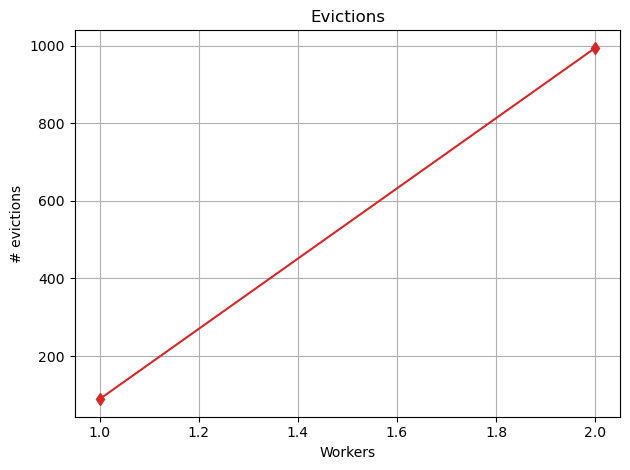

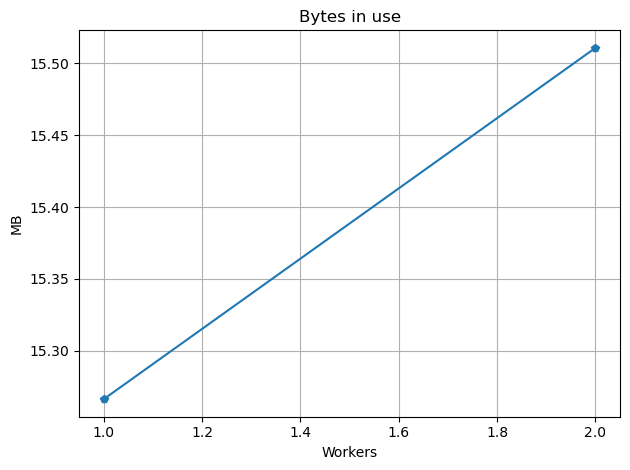

🔖 Results saved → state/stats/low_mem_big_obj_20250607_034018.json
Cleaned up all peers and networks.


In [2]:

run_benchmark(
    name="low_mem_big_obj",
    peers=4,
    memory_mb=4,
    value_size=64_000,
    scenarios=[(1, 200), (2, 400)],
)
!pkill -f memcached && rm -rf state/peer/*.json state/network/*.json && echo "Cleaned up all peers and networks."


▶ Stage: 4 workers × 1000 req
{
  "workers": 4,
  "reqs": 1000,
  "ops": 8000,
  "dur": 6.834044834016822,
  "thr": 1170.609821021304,
  "lat_avg": 3402.4537436039277,
  "lat_p95": 5361.666,
  "hits": 3231,
  "misses": 0,
  "hit_rate": 1.0,
  "evictions": 0,
  "bytes": 131327560
}

▶ Stage: 8 workers × 2000 req
{
  "workers": 8,
  "reqs": 2000,
  "ops": 32000,
  "dur": 25.266413125005784,
  "thr": 1266.5034740657386,
  "lat_avg": 6277.826187092749,
  "lat_p95": 9163.917,
  "hits": 6228,
  "misses": 6624,
  "hit_rate": 0.484593837535014,
  "evictions": 10361,
  "bytes": 252024486
}

🔧 Configuration:
{
  "name": "read_heavy",
  "peers": 8,
  "memory_mb": 32,
  "value_size": 16384,
  "ghost_ratio": 0.0,
  "ttl_ratio": 0.0,
  "scenarios": [
    [
      4,
      1000
    ],
    [
      8,
      2000
    ]
  ],
  "seed": 42
}
🖼️ Saved plot → state/stats/read_heavy_throughput.png
🖼️ Saved plot → state/stats/read_heavy_latency.png
🖼️ Saved plot → state/stats/read_heavy_hit_miss.png
🖼️ Saved p

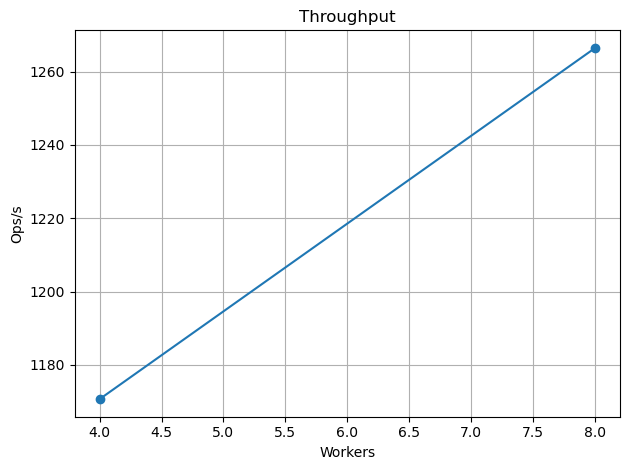

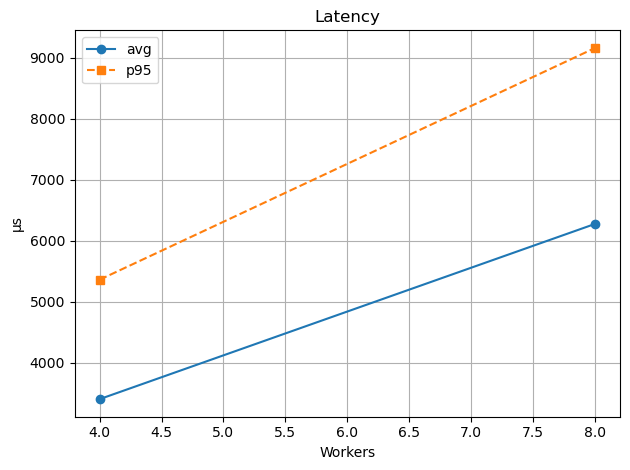

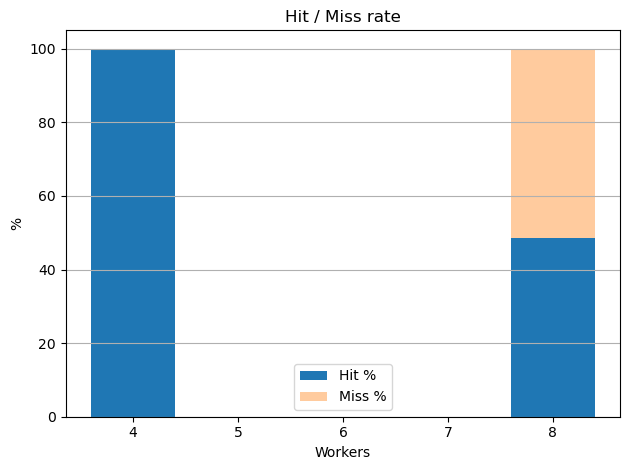

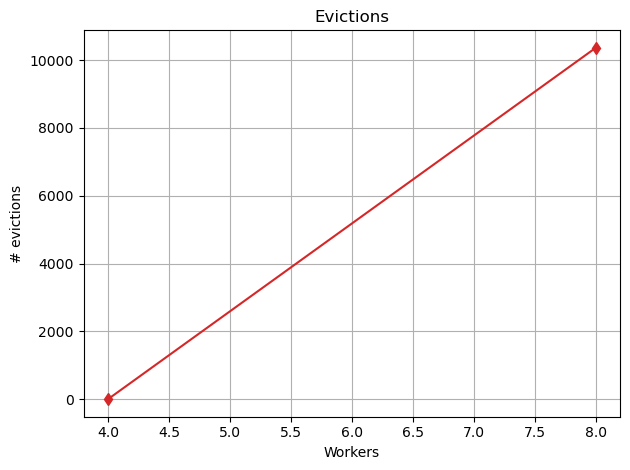

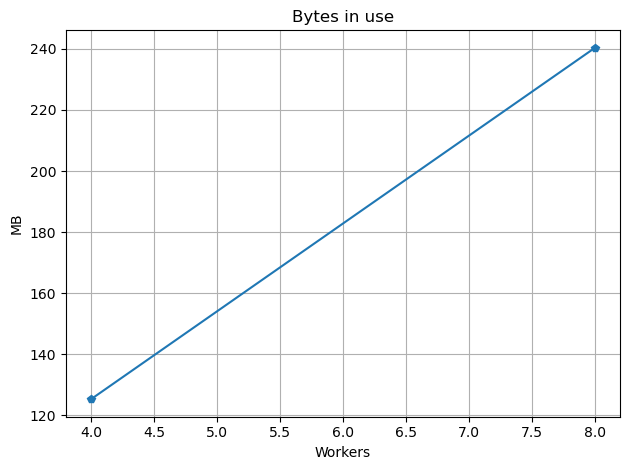

🔖 Results saved → state/stats/read_heavy_20250607_034106.json
Cleaned up all peers and networks.


In [3]:

run_benchmark(
    name="read_heavy",
    ghost_ratio=0.0,
    ttl_ratio=0.0,
    scenarios=[(4, 1_000), (8, 2_000)],
)
!pkill -f memcached && rm -rf state/peer/*.json state/network/*.json && echo "Cleaned up all peers and networks."